In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import glob

from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.resnet import preprocess_input, ResNet50
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten , Dense
from tensorflow.python.keras.models import load_model
import matplotlib.pyplot as plt 

In [2]:
NEW_DIR = "./database/"
ROOT_DIR = "./images/"

TRAIN_PATH  = "./database/train_test_split/train"
VALID_PATH  = "./database/train_test_split/validation"
TEST_PATH   = "./database/train_test_split/test"

objArrayDiseases = ["COVID", "Normal"]

In [3]:
objArrayCovid = pd.read_excel("./metadatas/covid.metadata.xlsx")
objArrayNormal = pd.read_excel("./metadatas/normal.metadata.xlsx")

In [4]:
if not os.path.exists(NEW_DIR):
  os.mkdir(NEW_DIR)

  for i in objArrayDiseases:
    org_dir = os.path.join(ROOT_DIR, i+"/")
    
    for imgfile in glob.iglob(os.path.join(org_dir, "*.png")):
      shutil.copy(imgfile, NEW_DIR)
      
else:
  print("Already Exist")

Already Exist


In [5]:
if not os.path.exists(NEW_DIR+"train_test_split/"):

  os.makedirs(NEW_DIR+"train_test_split/")

  os.makedirs(NEW_DIR+"train_test_split/train/Normal")
  os.makedirs(NEW_DIR+"train_test_split/train/COVID")

  os.makedirs(NEW_DIR+"train_test_split/test/Normal")
  os.makedirs(NEW_DIR+"train_test_split/test/COVID")

  os.makedirs(NEW_DIR+"train_test_split/validation/Normal")
  os.makedirs(NEW_DIR+"train_test_split/validation/COVID")


  # Train Data
  for i in np.random.choice(replace= False , size= 3000 , a = glob.glob(NEW_DIR+objArrayDiseases[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 3900 , a = glob.glob(NEW_DIR+objArrayDiseases[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Normal" )
    os.remove(i)

  # Validation Data
  for i in np.random.choice(replace= False , size= 308 , a = glob.glob(NEW_DIR+objArrayDiseases[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 500 , a = glob.glob(NEW_DIR+objArrayDiseases[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Normal" )
    os.remove(i)

  # Test Data
  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+objArrayDiseases[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+objArrayDiseases[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Normal" )
    os.remove(i)

In [6]:
objTrainGenerator = ImageDataGenerator(preprocessing_function= preprocess_input, 
                                    zoom_range= 0.2, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    
                                    )

objTrain = objTrainGenerator.flow_from_directory(directory= TRAIN_PATH, 
                                           target_size=(224,224))

Found 6900 images belonging to 2 classes.


In [7]:
objValidGenerator = ImageDataGenerator(preprocessing_function= preprocess_input  )

valid = objValidGenerator.flow_from_directory(directory= VALID_PATH, 
                                                target_size=(224,224))

Found 808 images belonging to 2 classes.


In [8]:
objTestGenerator = ImageDataGenerator(preprocessing_function= preprocess_input )

test = objTestGenerator.flow_from_directory(directory= TEST_PATH , 
                                          target_size=(224,224), 
                                          shuffle= False)

Found 600 images belonging to 2 classes.


In [9]:
classifier = ResNet50( input_shape=(224,224,3), include_top= False)

for layer in classifier.layers:       
  layer.trainable = False

In [10]:
print (classifier.output)

objLayers = Flatten()(classifier.output)
objLayers = Dense(units=2 , activation='sigmoid', name = 'predictions' )(objLayers)

objModel = Model(classifier.input, objLayers)
objModel.compile( optimizer= 'adam' , loss = 'categorical_crossentropy', metrics=['accuracy'])
objModel.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 2048), dtype=tf.float32, name=None), name='conv5_block3_out/Relu:0', description="created by layer 'conv5_block3_out'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormal

In [11]:
earlyStopping = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
modelCheckpoint = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

In [12]:
objFit = objModel.fit_generator(objTrain, steps_per_epoch= 10, epochs= 30, validation_data= valid , validation_steps= 16, callbacks=[earlyStopping, modelCheckpoint])

C:\Users\gabri\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
10/10 [==============================] - 106s 11s/step - loss: 14.8094 - accuracy: 0.5562 - val_loss: 10.6895 - val_accuracy: 0.6367

Epoch 00001: val_accuracy improved from -inf to 0.63672, saving model to bestmodel.h5


C:\Users\gabri\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
10/10 [==============================] - 99s 10s/step - loss: 6.6719 - accuracy: 0.7812 - val_loss: 3.7369 - val_accuracy: 0.8418

Epoch 00002: val_accuracy improved from 0.63672 to 0.84180, saving model to bestmodel.h5
Epoch 3/30
10/10 [==============================] - 97s 10s/step - loss: 2.7705 - accuracy: 0.8562 - val_loss: 1.9365 - val_accuracy: 0.8789

Epoch 00003: val_accuracy improved from 0.84180 to 0.87891, saving model to bestmodel.h5
Epoch 4/30
10/10 [==============================] - 94s 10s/step - loss: 3.0519 - accuracy: 0.8406 - val_loss: 2.4115 - val_accuracy: 0.8398

Epoch 00004: val_accuracy did not improve from 0.87891
Epoch 5/30
10/10 [==============================] - 86s 9s/step - loss: 2.1184 - accuracy: 0.8719 - val_loss: 1.3425 - val_accuracy: 0.8906

Epoch 00005: val_accuracy improved from 0.87891 to 0.89062, saving model to bestmodel.h5
Epoch 6/30
10/10 [==============================] - 87s 9s/step - loss: 1.9968 - accuracy: 0.8562 - val_loss: 1

In [13]:
objModel = load_model("bestmodel.h5")

nr_Acurracy = objModel.evaluate_generator(generator= test)[1] 

print(f"A acurácia do modelo selecionado foi de = {nr_Acurracy}%")

C:\Users\gabri\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:2002: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


A acurácia do modelo selecionado foi de = 0.8949999809265137%


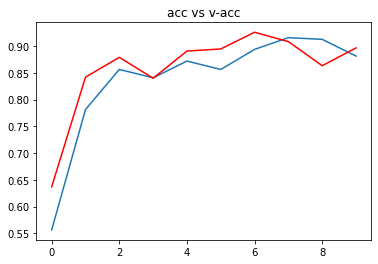

In [14]:
objHistory = objFit.history

plt.plot(objHistory['accuracy'])
plt.plot(objHistory['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

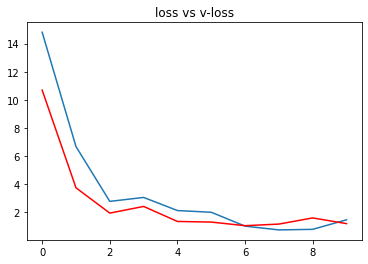

In [15]:
objHistory = objFit.history

plt.plot(objHistory['loss'])
plt.plot(objHistory['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()